In [100]:
import pandas as pd
from pathlib import Path

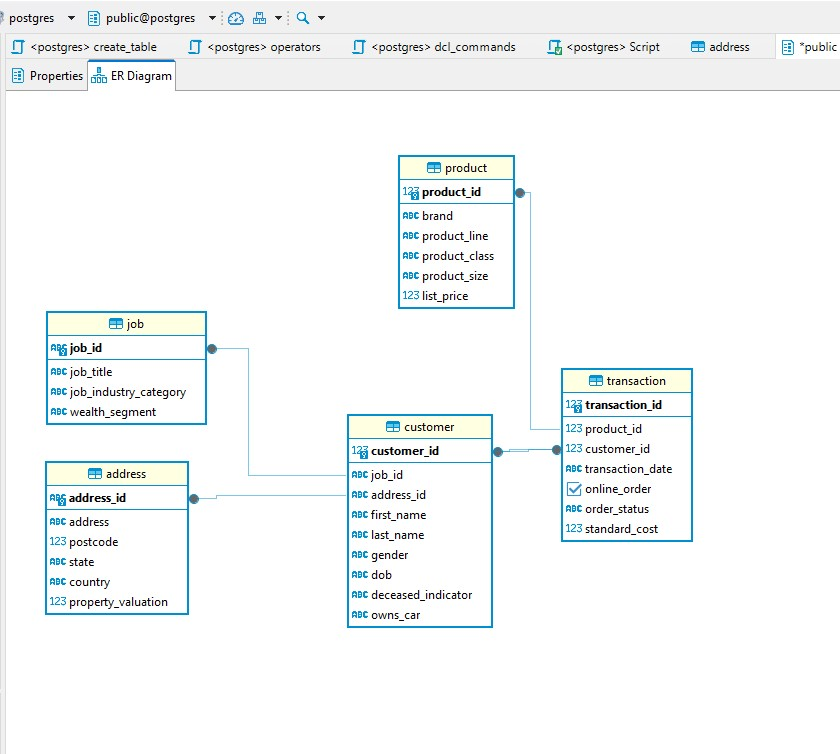

### загрузка данных для процессинга, создание колнок job_id, address_id

In [154]:
excel_path = Path()/'data'/'customer_and_transaction__2.xlsx'

transaction = pd.read_excel(excel_path, sheet_name='transaction', header=0)
customer = pd.read_excel(excel_path, sheet_name='customer', header=0)

customer['job_id'] = customer['job_title'] + customer['job_industry_category']
customer['job_id'] = customer['job_id'].apply(hash)

customer['address_id'] = customer['address'] + str(customer['postcode'])
customer['address_id'] = customer['address_id'].apply(hash)

customer['DOB'] = pd.to_datetime(customer['DOB'], dayfirst=False)


### декомпозиция таблиц, препроцессинг данных, выгрузка в csv

In [156]:
product = transaction[['product_id', 'brand', 'product_line', 'product_class', 'product_size', 'list_price']]
transaction = transaction[['transaction_id', 'product_id', 'customer_id', 'transaction_date', 'online_order', 'order_status', 'standard_cost']]

address = customer[['address_id', 'address', 'postcode', 'state', 'country', 'property_valuation']]
job = customer[['job_id', 'job_title', 'job_industry_category', 'wealth_segment']]
customer = customer[['customer_id', 'job_id', 'address_id', 'first_name', 'last_name', 'gender', 'DOB', 'deceased_indicator', 'owns_car']]

product.drop_duplicates(inplace=True)
transaction.drop_duplicates(inplace=True)
address.drop_duplicates(inplace=True)
job.drop_duplicates(inplace=True)
customer.drop_duplicates(inplace=True)

product.drop_duplicates(subset='product_id', inplace=True)
transaction.drop_duplicates(subset='transaction_id', inplace=True)
address.drop_duplicates(subset='address_id', inplace=True)
job.drop_duplicates(subset='job_id', inplace=True)
customer.drop_duplicates(subset='customer_id', inplace=True)

transaction['online_order'].fillna(False, inplace=True)
transaction.dropna(subset='standard_cost', inplace=True)

product.to_csv('data/product.csv', index=False)
transaction.to_csv('data/transaction.csv', index=False)
address.to_csv('data/address.csv', index=False)
job.to_csv('data/job.csv', index=False)
customer.to_csv('data/customer.csv', index=False)

### подключение к БД

In [139]:
import psycopg2 as pg
import json

In [84]:
with open('credentials.json') as f:
    data = json.load(f)
    username = data['username']
    password = data['password']
    
conn = pg.connect(dbname='hw1_customer_transactions', host='localhost', user=username, password=password, port=5432)
cursor = conn.cursor()

### Создание таблиц

In [85]:
cursor.execute("""
               CREATE TABLE IF NOT EXISTS product (
               product_id INT PRIMARY KEY,
               brand TEXT,
               product_line VARCHAR(15),
               product_class VARCHAR(15),
               product_size VARCHAR(10),
               list_price FLOAT8 NOT NULL
               )
               """)

cursor.execute("""
               CREATE TABLE IF NOT EXISTS transaction (
               transaction_id INT PRIMARY KEY,
               product_id INT NOT NULL,
               customer_id INT NOT NULL,
               transaction_date VARCHAR(10) NOT NULL,
               online_order BOOL,
               order_status VARCHAR(10) NOT NULL,
               standard_cost FLOAT8 NOT NULL
               )
               """)

cursor.execute("""
               CREATE TABLE IF NOT EXISTS customer (
               customer_id INT PRIMARY KEY,
               job_id VARCHAR(20) NOT NULL,
               address_id VARCHAR(20) NOT NULL,
               first_name TEXT NOT NULL,
               last_name TEXT NOT NULL,
               gender VARCHAR(6) NOT NULL,
               DOB VARCHAR(10) NOT NULL,
               deceased_indicator VARCHAR(1) NOT NULL,
               owns_car VARCHAR(3) NOT NULL
               )
               """)

cursor.execute("""
               CREATE TABLE IF NOT EXISTS job (
               job_id VARCHAR(20) PRIMARY KEY,
               job_title TEXT,
               job_industry_category TEXT,
               wealth_segment TEXT
               )
               """)

cursor.execute("""
               CREATE TABLE IF NOT EXISTS address (
               address_id VARCHAR(20) PRIMARY KEY,
               address TEXT NOT NULL,
               postcode INT NOT NULL,
               state TEXT,
               country TEXT NOT NULL,
               property_valuation INT
               )
               """)

try:
    conn.commit()
except (Exception, pg.Error, pg.DatabaseError) as error :
      print ("Ошибка в транзакции.", error)
      conn.rollback()

### Загрузка данных из csv в БД

In [112]:
with open('data/address.csv', 'r') as f:
    next(f)
    cursor.copy_from(f, 'address', sep=',')

try:
    conn.commit()
except (Exception, pg.Error, pg.DatabaseError) as error :
      print ("Ошибка в транзакции.", error)
      conn.rollback()

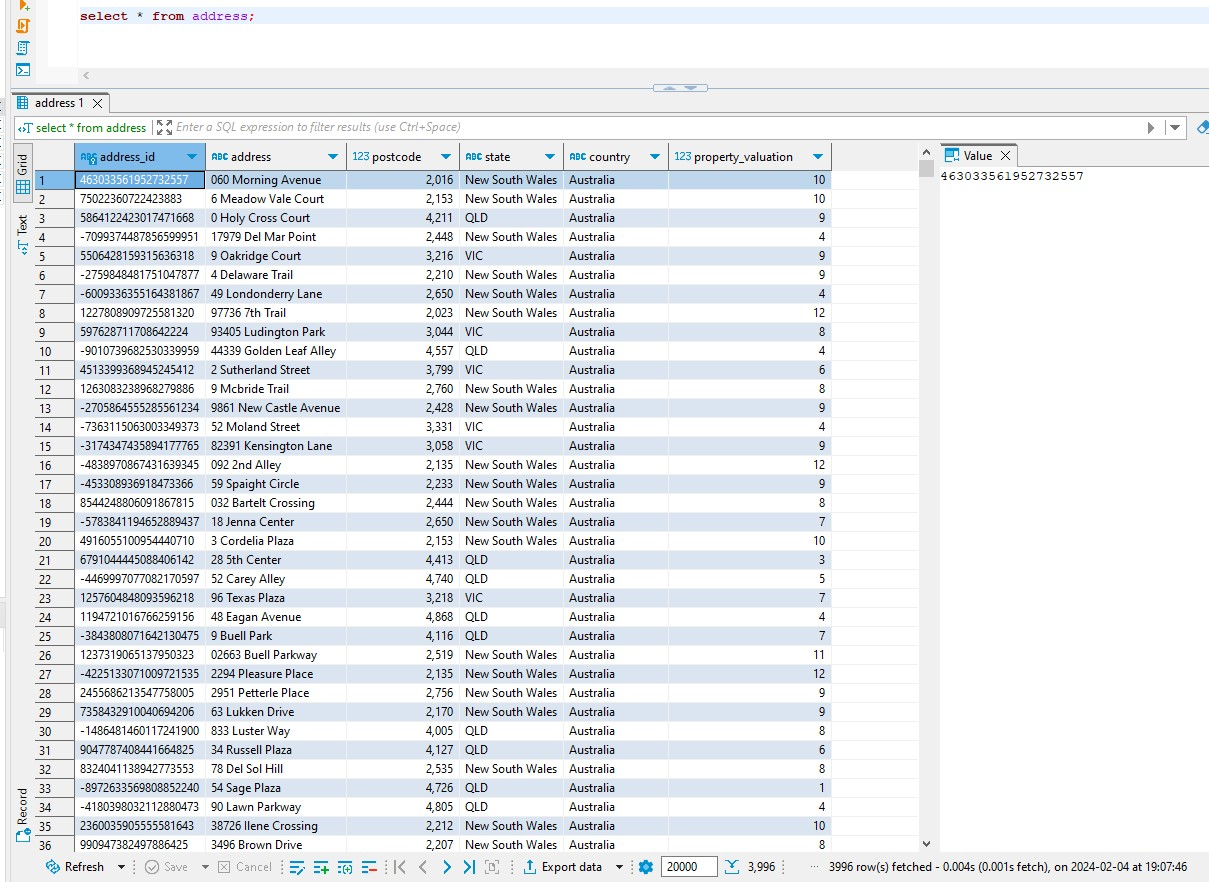

In [118]:
with open('data/customer.csv', 'r') as f:
    next(f)
    cursor.copy_from(f, 'customer', sep=',')

try:
    conn.commit()
except (Exception, pg.Error, pg.DatabaseError) as error :
      print ("Ошибка в транзакции.", error)
      conn.rollback()

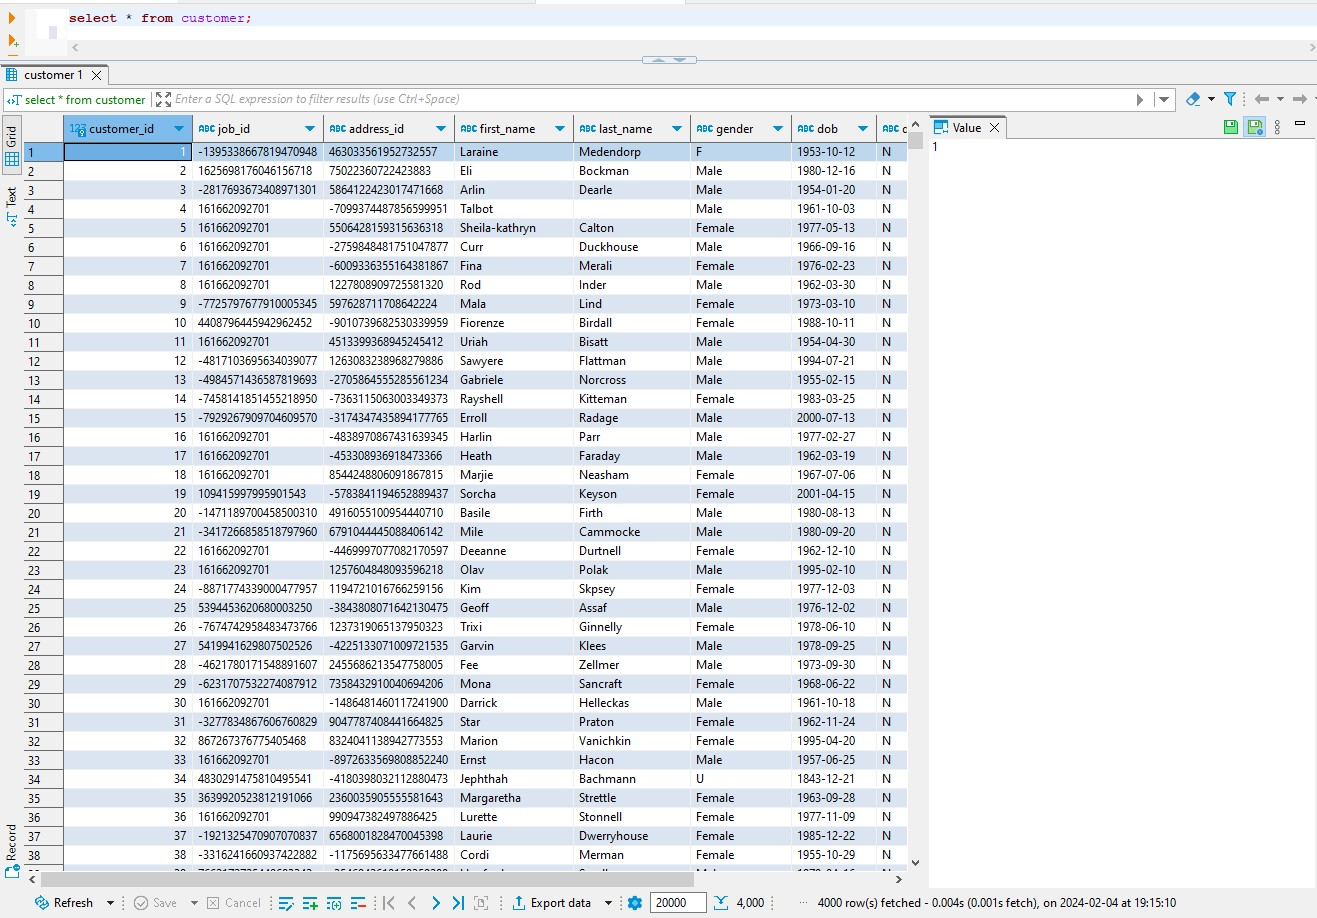

In [126]:
with open('data/job.csv', 'r') as f:
    next(f)
    cursor.copy_from(f, 'job', sep=',')

try:
    conn.commit()
except (Exception, pg.Error, pg.DatabaseError) as error :
      print ("Ошибка в транзакции.", error)
      conn.rollback()

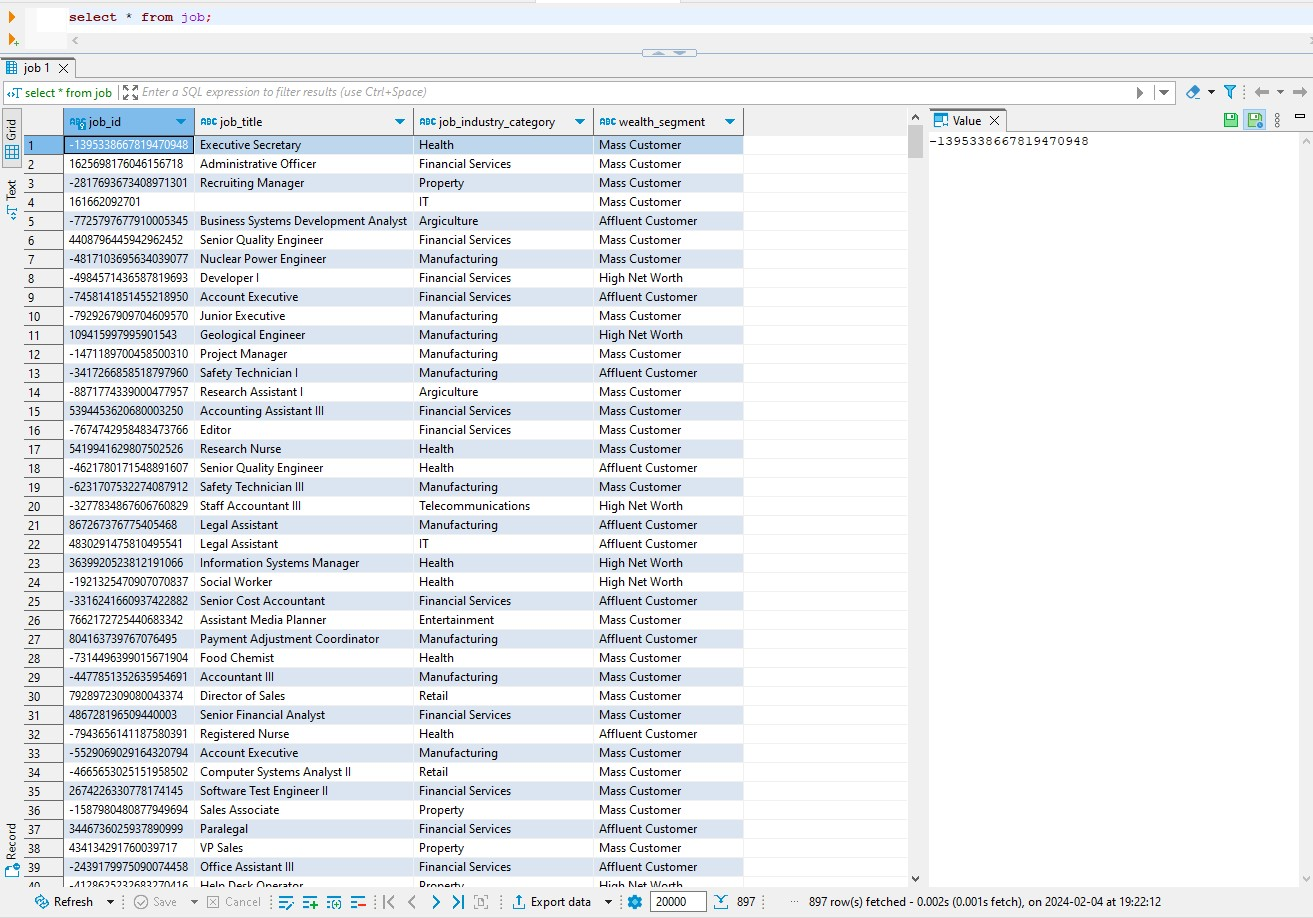

In [161]:
with open('data/product.csv', 'r') as f:
    next(f)
    cursor.copy_from(f, 'product', sep=',')

try:
    conn.commit()
except (Exception, pg.Error, pg.DatabaseError) as error :
      print ("Ошибка в транзакции.", error)
      conn.rollback()

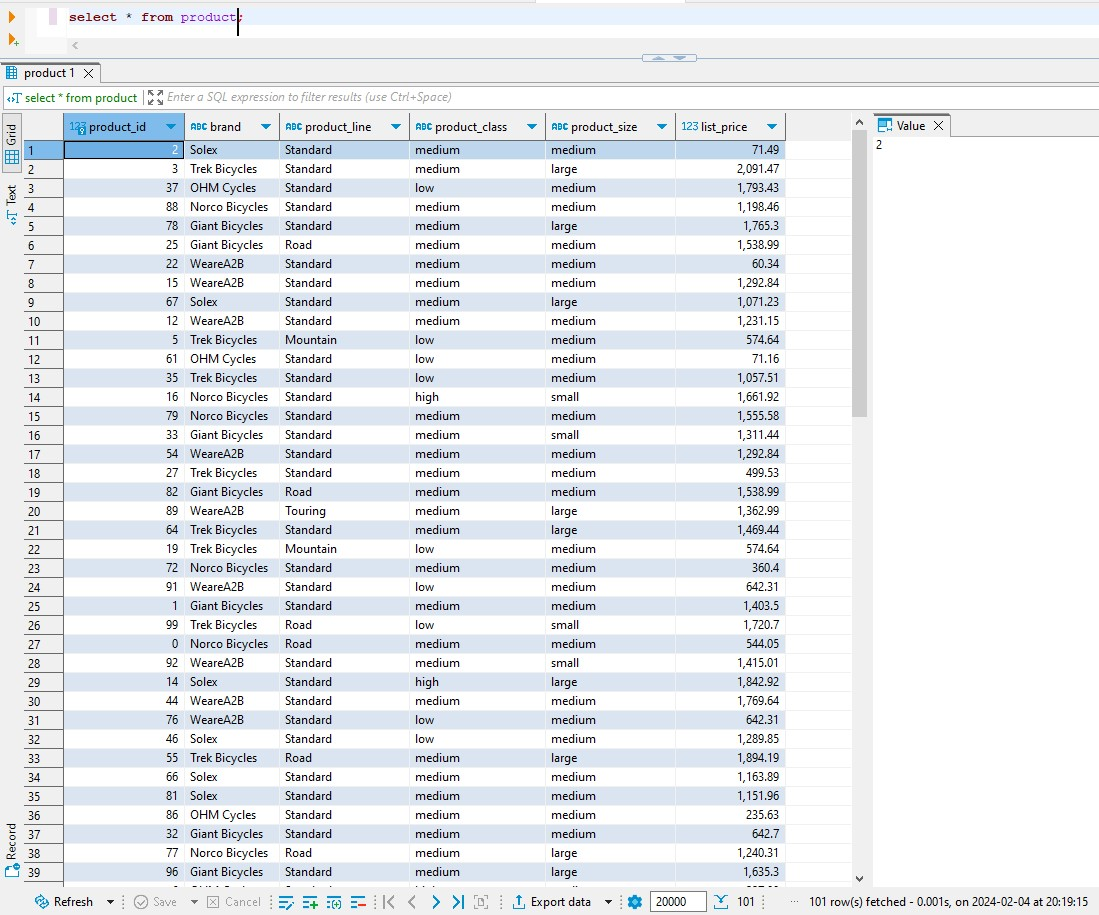

In [160]:
with open('data/transaction.csv', 'r') as f:
    next(f)
    cursor.copy_from(f, 'transaction', sep=',')

try:
    conn.commit()
except (Exception, pg.Error, pg.DatabaseError) as error :
      print ("Ошибка в транзакции.", error)
      conn.rollback()

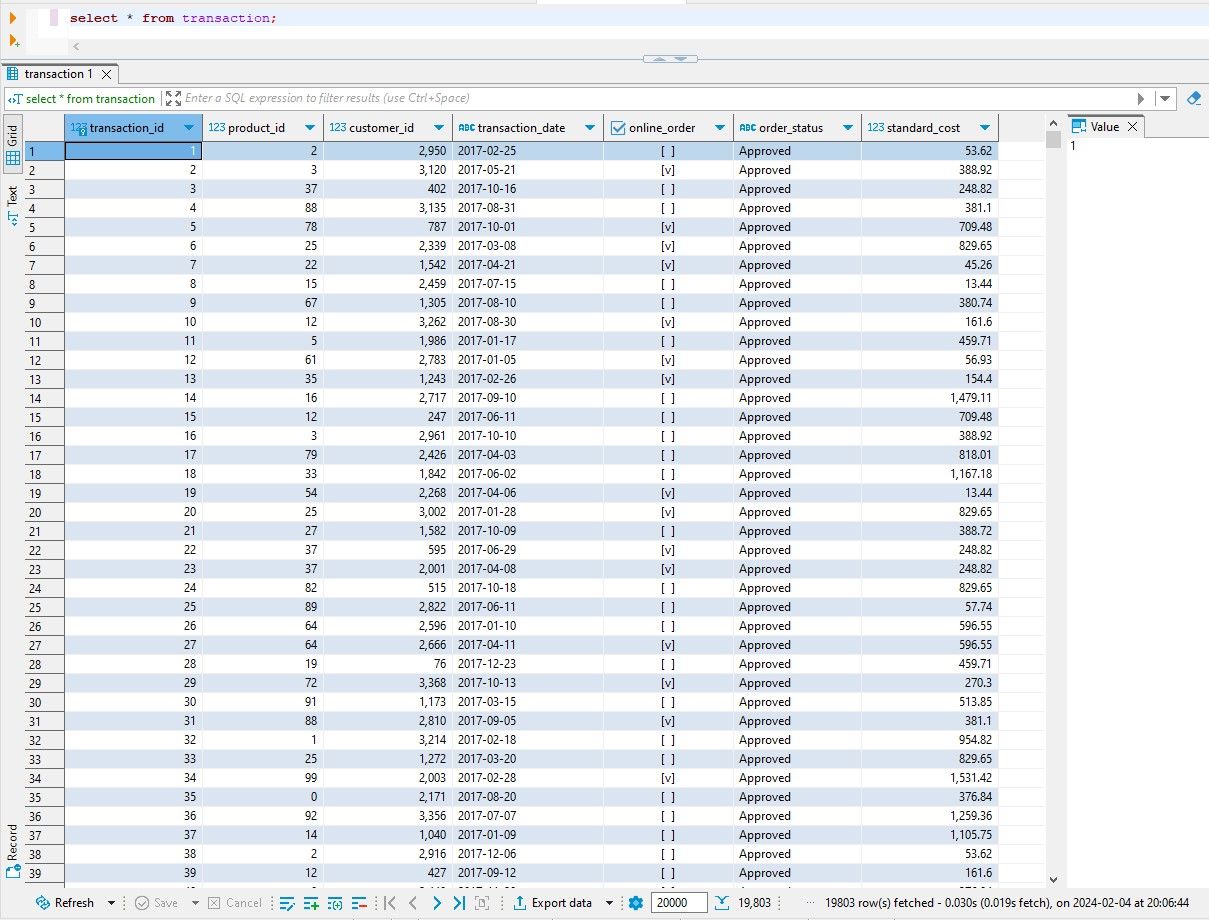

In [68]:
cursor.close()
conn.close()